### Load packages

In [74]:
from google.colab import files
import json


with open('/content/drive/MyDrive/Crowdfunding/keys.json') as f:
    license_keys = json.load(f)

In [75]:
import os
import csv
import io
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import spacy


secret = license_keys['SECRET']
os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['AWS_ACCESS_KEY_ID'] = license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']
sparknlp_version = license_keys["PUBLIC_VERSION"]
jsl_version = license_keys["JSL_VERSION"]

print ('SparkNLP Version:', sparknlp_version)
print ('SparkNLP-JSL Version:', jsl_version)

# Install Java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==$sparknlp_version
! python -m pip install --upgrade spark-nlp-jsl==$jsl_version --extra-index-url https://pypi.johnsnowlabs.com/$secret

os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ['PATH'] = os.environ['JAVA_HOME'] + "/bin:" + os.environ['PATH']

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

import sparknlp
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

spark = sparknlp_jsl.start(secret)

SparkNLP Version: 2.6.5
SparkNLP-JSL Version: 2.7.2
openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)
  Using cached https://files.pythonhosted.org/packages/c6/1d/9a2a7c17fc3b3aa78b3921167feed4911d5a055833fea390e7741bba0870/spark_nlp-2.6.5-py2.py3-none-any.whl


Looking in indexes: https://pypi.org/simple, https://pypi.johnsnowlabs.com/2.7.2-7ad44c2a1a61c48b6a74446b0a7cb6b97c58dba0
Requirement already up-to-date: spark-nlp-jsl==2.7.2 in /usr/local/lib/python3.6/dist-packages (2.7.2)


### Import feed data

In [11]:
#crowdfunding/json/rounds_3-6_for_prodigy.json
with open('/content/drive/MyDrive/Crowdfunding/rounds_3-6_for_prodigy.json') as json_file:
    feed = json.load(json_file)

In [76]:
feed = pd.DataFrame(feed)
print(feed.shape)
feed.head()

(197, 2)


,url,text
0,https://www.gofundme.com/f/please-help-karens-...,Help save my daughter's healthImagine having a...
1,https://www.gofundme.com/f/patrickwalter,"Patrick Walter is one of the kindest, funniest..."
2,https://www.gofundme.com/f/gspdys,"As most of you know, Alexander was born with H..."
3,https://www.gofundme.com/f/shane-blanchard039s...,"Friends of Shane Blanchard, we are requesting ..."
4,https://www.gofundme.com/f/2t4nqbuk,"Hello everyone, My name is Nicole Manzolli. I ..."


### Text preprocessing

Text has already had the following preprocessing steps in "Make qualtrics survey" notebook


```
feed = feed.drop_duplicates('url')

feed['nchar']= [len(x) for x in feed['fund_description']]
feed = feed[feed['nchar'] >= 100]

#regular expression to remove url
url_reg = r'(?:(?:http|https):\/\/)?([-a-zA-Z0-9.]{2,256}\.[a-z]{2,4})\b(?:\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?'

#regular expression to remove emojis
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

feed['fund_description'] = [bs(x).get_text().replace("\n","").replace(u'\xa0', u' ') for x in feed['fund_description']]
feed['fund_description'] = [re.sub(url_reg,"",x) for x in feed['fund_description']]
feed['fund_description'] = [emoji_pattern.sub(r'', x) for x in feed['fund_description']]
feed['fund_description'] = [x.strip() for x in feed['fund_description']]


feed['nchar']= [len(x) for x in feed['fund_description']]
feed = feed[feed['nchar'] >= 100]
```



The spark tokenizer does not work reliably to tokenize on punctuation without whitespace e.g. "end.Beginning"

So will preprocess this manually to split tokens by .,!?

In [77]:
import re

def CustomTokenize(df):
  r = []
  for i in range(len(df)):
    string = re.sub(r'(?<=[.,!\\?])(?=[^\s])', r' ', df['text'][i])
    r.append(string)
  return r

In [78]:
feed.loc[:,'text_clean'] = CustomTokenize(feed)
del feed['text']
feed = feed.rename(columns={'text_clean':'text'})

### Tokenize with Spark NLP

#### Define pipeline elements

In [79]:
document_assembler = DocumentAssembler() \
    .setInputCol('text')\
    .setOutputCol('document')

sentence_detector = SentenceDetector() \
    .setInputCols(['document'])\
    .setOutputCol('sentence')

tokenizer = Tokenizer()\
    .setInputCols(['sentence']) \
    .setOutputCol('token')

#### Define Functions

In [80]:
def Tokenize(feed, first_column):
  '''
  input:
    1. pandas dataframe of feed data, col_1 = "url", col_2 = "text"
    3. string of first column name
  output: pandas dataframe with nested results
  '''

  #initiate empty df
  empty_df = spark.createDataFrame([['']]).toDF(first_column)
  
  #load feed data into df
  df = spark.createDataFrame(feed)
  
  nlp_pipeline = Pipeline(stages=[
      document_assembler, 
      sentence_detector,
      tokenizer])

  model = nlp_pipeline.fit(empty_df)
  result = model.transform(df)
  print('all done')
  return result.toPandas()
  

#### Execute functions

In [81]:
tokenized_text = Tokenize(feed, 'text')

all done


### Inspect tokenized text

In [82]:
tokenized_text.head()

,url,text,document,sentence,token
0,https://www.gofundme.com/f/please-help-karens-...,Help save my daughter's healthImagine having a...,"[(document, 0, 4443, Help save my daughter's h...","[(document, 0, 168, Help save my daughter's he...","[(token, 0, 3, Help, {'sentence': '0'}, []), (..."
1,https://www.gofundme.com/f/patrickwalter,"Patrick Walter is one of the kindest, funniest...","[(document, 0, 678, Patrick Walter is one of t...","[(document, 0, 77, Patrick Walter is one of th...","[(token, 0, 6, Patrick, {'sentence': '0'}, [])..."
2,https://www.gofundme.com/f/gspdys,"As most of you know, Alexander was born with H...","[(document, 0, 531, As most of you know, Alexa...","[(document, 0, 75, As most of you know, Alexan...","[(token, 0, 1, As, {'sentence': '0'}, []), (to..."
3,https://www.gofundme.com/f/shane-blanchard039s...,"Friends of Shane Blanchard, we are requesting ...","[(document, 0, 1598, Friends of Shane Blanchar...","[(document, 0, 165, Friends of Shane Blanchard...","[(token, 0, 6, Friends, {'sentence': '0'}, [])..."
4,https://www.gofundme.com/f/2t4nqbuk,"Hello everyone, My name is Nicole Manzolli. I ...","[(document, 0, 3789, Hello everyone, My name i...","[(document, 0, 42, Hello everyone, My name is ...","[(token, 0, 4, Hello, {'sentence': '0'}, []), ..."


In [83]:
token_length = []
for token_list in tokenized_text['token']:
  token_length.append(len(token_list))

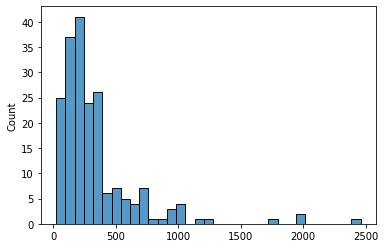

In [84]:
sns.histplot(token_length)

In [85]:
np.mean(token_length)

339.07106598984774

### Align prodigy tokens with spark

In [86]:
!pip install pytokenizations==0.7.2

     |████████████████████████████████| 245kB 6.7MB/s 


In [87]:
import tokenizations

2/8/21

Import prodigy data annotated for DIAGNOSIS, TEST, TREATMENT

In [91]:
#import prodigy data
import json
p = []
for line in open('/content/drive/MyDrive/Crowdfunding/dx_tx_test_annotations_corrected.json', 'r'):
    p.append(json.loads(line))

In [92]:
len(p)

197

In [93]:
#gather text and spans
text = [x['text'] for x in p]
spans = []
for i in range(len(p)):
  if 'spans' in p[i].keys():
    spans.append(p[i]['spans'])
  else:
    spans.append([])

In [94]:
text[0][:50]

'Patrick Walter is one of the kindest, funniest, mo'

In [95]:
spans[0]

[{'end': 355,
  'label': 'DIAGNOSIS',
  'start': 347,
  'token_end': 77,
  'token_start': 77},
 {'end': 393,
  'label': 'TREATMENT',
  'start': 381,
  'token_end': 83,
  'token_start': 83}]

In [96]:
#gather iob tags
prodigy_tags = []
for i in range(len(p)):
  nlp = spacy.blank("en")
  doc = nlp(text[i])
  offsets = [(span["start"], span["end"], span["label"]) for span in spans[i]]
  doc.ents = [doc.char_span(start, end, label) for start, end, label in offsets]
  iob_tags = [f"{t.ent_iob_}-{t.ent_type_}" if t.ent_iob_ else "O" for t in doc]
  prodigy_tags.append(iob_tags)

In [97]:
prodigy_tags[0][75:85]

['O', 'O', 'B-DIAGNOSIS', 'O', 'O', 'O', 'O', 'O', 'B-TREATMENT', 'O']

In [98]:
#gather prodigy tokens
prodigy_tokens = []
for i in range(len(p)):
  tokens = [x['text'] for x in p[i]['tokens']]
  prodigy_tokens.append(tokens)

In [99]:
prodigy_tokens[0][:10]

['Patrick',
 'Walter',
 'is',
 'one',
 'of',
 'the',
 'kindest',
 ',',
 'funniest',
 ',']

In [100]:
#gather spark-tokenized tokens
spark_tokens = []
for i in range(len(p)):
  url = p[i]['url']
  df = tokenized_text[tokenized_text['url'] == url]
  idx = df.index.tolist()[0]
  tokens = [x['result'] for x in df['token'][idx]]
  spark_tokens.append(tokens)

In [101]:
spark_tokens[0][:10]

['Patrick',
 'Walter',
 'is',
 'one',
 'of',
 'the',
 'kindest',
 ',',
 'funniest',
 ',']

In [102]:
def AlignOtherTokensToSpark(prodigy_tokens, prodigy_tags, spark_tokens, is_bert):

  #function inspired by:
  #https://gist.github.com/tamuhey/af6cbb44a703423556c32798e1e1b704

  aligned_tokens = []
  aligned_tags = []

  print('Length of prodigy tokens:',len(prodigy_tokens))
  print('Length of prodigy tags:',len(prodigy_tags))
  print('Length of spark tokens:',len(spark_tokens))

  for i in range(len(spark_tokens)):

    p_tokens = prodigy_tokens[i]
    p_tags = prodigy_tags[i]
    s_tokens = spark_tokens[i]

    #if bert
    if is_bert == 'True':
      print('is BERT')
      p_tokens = p_tokens[1:-1]
      p_tags = p_tags[1:-1]
    

    #align tokens
    a2b, b2a = tokenizations.get_alignments(s_tokens, p_tokens)

    #join aligned tokens and tags into list of same length as reference list
    tokens = []
    tags = []
    for i in range(len(a2b)):
      for j in a2b[i]:
        token = ''.join(p_tokens[j]).replace('#','').strip()
        tag = ''.join(p_tags[j]).strip()
      tokens.append(token)
      tags.append(tag)
    aligned_tokens.append(tokens)
    aligned_tags.append(tags)

  return aligned_tokens, aligned_tags

In [103]:
prodigy_aligned_tokens, prodigy_aligned_tags = AlignOtherTokensToSpark(prodigy_tokens, prodigy_tags, spark_tokens, False)

Length of prodigy tokens: 197
Length of prodigy tags: 197
Length of spark tokens: 197


Check that all document lengths align

In [104]:
for i in range(len(prodigy_aligned_tokens)):
  if len(prodigy_aligned_tokens[i]) != len(spark_tokens[i]):
    print(i,len(prodigy_aligned_tokens[i]), len(spark_tokens[i]))

Inspect alignment

In [105]:
j = 0

print(pd.DataFrame({'spark_tok':spark_tokens[j],'prod_tok':prodigy_aligned_tokens[j], 'prod_tag':prodigy_aligned_tags[j]}).head(10))
print('\n')

j = 13

print(pd.DataFrame({'spark_tok':spark_tokens[j],'prod_tok':prodigy_aligned_tokens[j], 'prod_tag':prodigy_aligned_tags[j]}).head(10))

  spark_tok  prod_tok prod_tag
0   Patrick   Patrick        O
1    Walter    Walter        O
2        is        is        O
3       one       one        O
4        of        of        O
5       the       the        O
6   kindest   kindest        O
7         ,         ,        O
8  funniest  funniest        O
9         ,         ,        O


     spark_tok     prod_tok prod_tag
0          The          The        O
1        staff        staff        O
2           on           on        O
3          the          the        O
4  Progressive  Progressive        O
5         Care         Care        O
6         Unit         Unit        O
7           at           at        O
8          JMH          JMH        O
9     hospital     hospital        O


Add rule-based injury diagnoses NER to gold standard

In [106]:
def AddRules(toks, tags):
  r_tok = []
  r_tag = []

  to_add = ["accident","injury","injuries","injured","crash","collision","injured","burn","burned","burns"]

  for token, tag in zip(toks,tags):
    camp_tags = []

    for i in range(len(token)):
      if any(s in token[i].lower() for s in to_add):
        if tag[i] == 'B-DIAGNOSIS':
          camp_tags.append(tag[i])
        elif tag[i] == 'I-DIAGNOSIS':
          camp_tags.append(tag[i])
        else:
          camp_tags.append('B-DIAGNOSIS')
      else:
        camp_tags.append(tag[i])
    
    r_tok.append(token)
    r_tag.append(camp_tags)
  
  return r_tok, r_tag

In [107]:
prodigy_aligned_tokens_with_rule, prodigy_aligned_tags_with_rule = AddRules(prodigy_aligned_tokens, prodigy_aligned_tags)

In [108]:
j = 0

print(pd.DataFrame({'spark_tok':spark_tokens[j],'prod_tok':prodigy_aligned_tokens_with_rule[j], 'prod_tag':prodigy_aligned_tags_with_rule[j]}).head(10))
print('\n')

  spark_tok  prod_tok prod_tag
0   Patrick   Patrick        O
1    Walter    Walter        O
2        is        is        O
3       one       one        O
4        of        of        O
5       the       the        O
6   kindest   kindest        O
7         ,         ,        O
8  funniest  funniest        O
9         ,         ,        O




### Compare NER results to prodigy

#### Diagnosis (NER_JSL)

Go ahead and run NER here since spark is installed

In [88]:
word_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token']) \
    .setOutputCol('embeddings')

ner_clinical = NerDLModel.pretrained('ner_clinical', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_diseases = NerDLModel.pretrained('ner_diseases', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_jsl = NerDLModel.pretrained('ner_jsl', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_jsl_wip = NerDLModel.pretrained('jsl_ner_wip_clinical', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_converter = NerConverter()\
    .setInputCols(['sentence', 'token', 'ner']) \
    .setOutputCol('ner_chunk')

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_diseases download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14 MB
[OK!]
jsl_ner_wip_clinical download started this may take some time.
Approximate size to download 14.5 MB
[OK!]


In [89]:
def RunNER(feed, ner_model, first_column):
  '''
  input:
    1. pandas dataframe of feed data, col_1 = "url", col_2 = "text"
    2. string of ner model
    3. string of first column name
  output: pandas dataframe with nested results
  '''

  #initiate empty df
  empty_df = spark.createDataFrame([['']]).toDF(first_column)
  
  #load feed data into df
  df = spark.createDataFrame(feed)
  
  if ner_model == 'ner_clinical':

    nlp_pipeline = Pipeline(stages=[
        document_assembler, 
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_clinical,
        ner_converter])

    ner_model = nlp_pipeline.fit(empty_df)
    result = ner_model.transform(df)
    return result.toPandas()
  
  if ner_model == 'ner_diseases':

    nlp_pipeline = Pipeline(stages=[
        document_assembler, 
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_diseases,
        ner_converter])

    ner_model = nlp_pipeline.fit(empty_df)
    result = ner_model.transform(df)
    return result.toPandas()
  
  if ner_model == 'ner_jsl':

    nlp_pipeline = Pipeline(stages=[
        document_assembler, 
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_jsl,
        ner_converter])

    ner_model = nlp_pipeline.fit(empty_df)
    result = ner_model.transform(df)
    return result.toPandas()
  
  if ner_model == 'ner_jsl_wip':
    print('ner_jsl_wip')

    nlp_pipeline = Pipeline(stages=[
        document_assembler, 
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_jsl_wip,
        ner_converter])

    ner_model = nlp_pipeline.fit(empty_df)
    result = ner_model.transform(df)
    return result.toPandas()

In [90]:
def Main(feed, all):
  r = []
  if all == 'True':
    for ner_model in ['ner_clinical']:
      ner_result = RunNER(feed, ner_model, 'text')
      ner_result.loc[:,'ner_model'] = [ner_model for x in range(ner_result.shape[0])]
      r.append(ner_result)
    df = pd.concat(r)
  elif all == 'wip':
    for ner_model in ['ner_jsl_wip']:
      ner_result = RunNER(feed, ner_model, 'text')
      ner_result.loc[:,'ner_model'] = [ner_model for x in range(ner_result.shape[0])]
      r.append(ner_result)
    df = pd.concat(r)
  else:
    for ner_model in ['ner_jsl']:
      ner_result = RunNER(feed, ner_model, 'text')
      ner_result.loc[:,'ner_model'] = [ner_model for x in range(ner_result.shape[0])]
      r.append(ner_result)
    df = pd.concat(r)
  return df

In [109]:
spark_ner = Main(feed, all=False)

In [110]:
#gather ner tags
ner_tags = []
for i in range(len(p)):
  url = p[i]['url']
  df = spark_ner[spark_ner['url'] == url]
  idx = df.index.tolist()[0]
  tags = [x['result'] for x in df['ner'][idx]]
  ner_tags.append(tags)

In [111]:
#gather ner tags and tokens
ner_tags = []
ner_tokens = []
for i in range(len(p)):
  url = p[i]['url']
  df = spark_ner[spark_ner['url'] == url]
  idx = df.index.tolist()[0]
  tags = [x['result'] for x in df['ner'][idx]]
  words = [x.metadata['word'] for x in df['ner'][idx]]
  ner_tags.append(tags)
  ner_tokens.append(words)

In [112]:
j = 19

print(pd.DataFrame({'ner_tok':ner_tokens[j],
                    'ner_tag':ner_tags[j],
                    'prod_tok':prodigy_aligned_tokens_with_rule[j],
                    'prod_tag':prodigy_aligned_tags_with_rule[j]})[15:30])
print('\n')

j = 23

print(pd.DataFrame({'ner_tok':ner_tokens[j],
                    'ner_tag':ner_tags[j],
                    'prod_tok':prodigy_aligned_tokens_with_rule[j],
                    'prod_tag':prodigy_aligned_tags_with_rule[j]})[40:60])

     ner_tok         ner_tag  prod_tok     prod_tag
15      week               O      week            O
16       ago               O       ago            O
17       for               O       for            O
18    having               O    having            O
19  seizures  B-Symptom_Name  seizures  B-DIAGNOSIS
20         .               O         .            O
21       She        B-Gender       She            O
22       has               O       has            O
23        no       B-Negated        no            O
24   history               O   history            O
25        of               O        of            O
26  seizures  B-Symptom_Name  seizures  B-DIAGNOSIS
27       and               O       and            O
28      Dr's               O        's            O
29      have               O      have            O


       ner_tok         ner_tag    prod_tok     prod_tag
40           "               O           "            O
41  spiculated      B-Modifier  spiculated            

In [113]:
def AddRules_NER(toks, tags):
  r_tag = []

  to_add = [
            "accident",
            "injury",
            "injuries",
            "crash",
            "collision",
            "injured",
            "fractured",
            "fracture",
            "seizure",
            "seizures",
            "tumor",
            "tumors",
            "tumour",
            "tumours",
            'aphasia',
            'paralysis',
            'paralyzed'
            'septic',
            'sepsis',
            'migraine',
            'migraines',
            'coma',
            'burn',
            'burned',
            'burns',
            'paraplegic',
            'paraplegia',
            'quadriplegic',
            'quadriplegia',
            'infection',
            'infections',
            'hepatitis',
            'cirhosis',
            'sarcodosis',
            'cancer',
            'leukemia',
            'clots',
            'carcinoma',
            'endocarditis',
            'arthritis'
            ]

  for token, tag in zip(toks,tags):
    camp_tags = []

    for i in range(len(token)):
      if any(s in token[i].lower() for s in to_add):
        if tag[i].upper() == 'B-DIAGNOSIS':
          camp_tags.append(tag[i].upper())
        elif tag[i].upper() == 'I-DIAGNOSIS':
          camp_tags.append(tag[i].upper())
        else:
          camp_tags.append('B-DIAGNOSIS')
      else:
        camp_tags.append(tag[i].upper())
    
    r_tag.append(camp_tags)
  
  return r_tag

In [114]:
ner_tags_with_rule = AddRules_NER(ner_tokens, ner_tags) #also makes uppercase

In [115]:
j = 19

print(pd.DataFrame({'ner_tok':ner_tokens[j],
                    'ner_tag':ner_tags_with_rule[j],
                    'prod_tok':prodigy_aligned_tokens_with_rule[j],
                    'prod_tag':prodigy_aligned_tags_with_rule[j]})[15:30])
print('\n')

j = 23

print(pd.DataFrame({'ner_tok':ner_tokens[j],
                    'ner_tag':ner_tags_with_rule[j],
                    'prod_tok':prodigy_aligned_tokens_with_rule[j],
                    'prod_tag':prodigy_aligned_tags_with_rule[j]})[40:60])

     ner_tok      ner_tag  prod_tok     prod_tag
15      week            O      week            O
16       ago            O       ago            O
17       for            O       for            O
18    having            O    having            O
19  seizures  B-DIAGNOSIS  seizures  B-DIAGNOSIS
20         .            O         .            O
21       She     B-GENDER       She            O
22       has            O       has            O
23        no    B-NEGATED        no            O
24   history            O   history            O
25        of            O        of            O
26  seizures  B-DIAGNOSIS  seizures  B-DIAGNOSIS
27       and            O       and            O
28      Dr's            O        's            O
29      have            O      have            O


       ner_tok         ner_tag    prod_tok     prod_tag
40           "               O           "            O
41  spiculated      B-MODIFIER  spiculated            O
42        mass  B-SYMPTOM_NAME        mass    

only include diagnosis

In [110]:
!pip install nervaluate==0.1.8

In [111]:
from nervaluate import Evaluator

In [348]:
evaluator = Evaluator(prodigy_aligned_tags_with_rule, ner_tags_with_rule, tags=['DIAGNOSIS'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 579,
 'correct': 508,
 'f1': 0.8348397699260476,
 'incorrect': 0,
 'missed': 130,
 'partial': 0,
 'possible': 638,
 'precision': 0.8773747841105354,
 'recall': 0.7962382445141066,
 'spurious': 71}

In [298]:
prodigy_aligned_tokens_with_rule_flat = [item for sublist in prodigy_aligned_tokens_with_rule for item in sublist]
prodigy_aligned_tags_with_rule_flat = [item for sublist in prodigy_aligned_tags_with_rule for item in sublist]
ner_tokens_flat = [item for sublist in ner_tokens for item in sublist]
ner_tags_with_rule_flat = [item for sublist in ner_tags_with_rule for item in sublist]

In [299]:
compare_dx = pd.DataFrame({
    'prod_tok':prodigy_aligned_tokens_with_rule_flat,
    'ner_tok':ner_tokens_flat,
    'prod_tag':prodigy_aligned_tags_with_rule_flat,
    'ner_tag':ner_tags_with_rule_flat
})

In [120]:
# compare_dx = compare_dx[(compare_dx['prod_tag'] != 'O') & (compare_dx['ner_tag'] != 'O')]

In [300]:
compare_dx.to_csv('/content/drive/MyDrive/Crowdfunding/compare_dx.csv', index=False)

#### Test (NER_CLINICAL)

In [225]:
spark_ner = Main(feed, all='True')

In [226]:
#gather ner tags
ner_tags = []
for i in range(len(p)):
  url = p[i]['url']
  df = spark_ner[spark_ner['url'] == url]
  idx = df.index.tolist()[0]
  tags = [x['result'] for x in df['ner'][idx]]
  ner_tags.append(tags)

In [227]:
#gather ner tags and tokens
ner_tags = []
ner_tokens = []
for i in range(len(p)):
  url = p[i]['url']
  df = spark_ner[spark_ner['url'] == url]
  idx = df.index.tolist()[0]
  tags = [x['result'] for x in df['ner'][idx]]
  words = [x.metadata['word'] for x in df['ner'][idx]]
  ner_tags.append(tags)
  ner_tokens.append(words)

In [228]:
j = 23

print(pd.DataFrame({'ner_tok':ner_tokens[j],
                    'ner_tag':ner_tags[j],
                    'prod_tok':prodigy_aligned_tokens[j],
                    'prod_tag':prodigy_aligned_tags[j]})[40:60])

       ner_tok        ner_tag    prod_tok     prod_tag
40           "              O           "            O
41  spiculated     B-Modifier  spiculated            O
42        mass      B-Symptom        mass            O
43      highly              O      highly            O
44  suspicious              O  suspicious            O
45          of              O          of            O
46  malignancy  B-Oncological  malignancy  B-DIAGNOSIS
47           .              O           .            O
48           "              O           "            O
49           I              O           I            O
50    returned              O    returned            O
51          on              O          on            O
52         May         B-Date         May            O
53        20th         I-Date        20th            O
54         for              O         for            O
55     another              O     another            O
56   mammogram         B-Test   mammogram       B-TEST
57        

In [230]:
#only include Test and Imaging_Technique

def Test_Img_Only(tags):
  r = []
  for camp in tags:
    subtags = []
    for tag in camp:
      if tag.upper() == 'B-TEST':
        subtags.append('B-TEST')
      elif tag.upper() == 'I-TEST':
        subtags.append('I-TEST')
      elif tag.upper() == 'B-IMAGING_TECHNIQUE':
        subtags.append('B-TEST')
      elif tag.upper() == 'I-IMAGING_TECHNIQUE':
        subtags.append('I-TEST')
      else:
        subtags.append('O')
    r.append(subtags)
  return r

In [231]:
ner_tags_clean = Test_Img_Only(ner_tags)

In [232]:
evaluator = Evaluator(prodigy_aligned_tags, ner_tags_clean, tags=['TEST'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 127,
 'correct': 74,
 'f1': 0.6636771300448431,
 'incorrect': 0,
 'missed': 22,
 'partial': 0,
 'possible': 96,
 'precision': 0.5826771653543307,
 'recall': 0.7708333333333334,
 'spurious': 53}

In [237]:
prodigy_aligned_tokens_flat = [item for sublist in prodigy_aligned_tokens for item in sublist]
prodigy_aligned_tags_flat = [item for sublist in prodigy_aligned_tags for item in sublist]
ner_tokens_flat = [item for sublist in ner_tokens for item in sublist]
ner_tags_flat = [item for sublist in ner_tags_clean for item in sublist]

In [238]:
compare_test = pd.DataFrame({
    'prod_tok':prodigy_aligned_tokens_flat,
    'ner_tok':ner_tokens_flat,
    'prod_tag':prodigy_aligned_tags_flat,
    'ner_tag':ner_tags_flat
})

In [239]:
compare_test.to_csv('/content/drive/MyDrive/Crowdfunding/compare_test.csv', index=False)

#### Treatment (NER_CLINICAL)

In [243]:
spark_ner = Main(feed, all='True')

In [245]:
#gather ner tags
ner_tags = []
for i in range(len(p)):
  url = p[i]['url']
  df = spark_ner[spark_ner['url'] == url]
  idx = df.index.tolist()[0]
  tags = [x['result'] for x in df['ner'][idx]]
  ner_tags.append(tags)

In [246]:
#gather ner tags and tokens
ner_tags = []
ner_tokens = []
for i in range(len(p)):
  url = p[i]['url']
  df = spark_ner[spark_ner['url'] == url]
  idx = df.index.tolist()[0]
  tags = [x['result'] for x in df['ner'][idx]]
  words = [x.metadata['word'] for x in df['ner'][idx]]
  ner_tags.append(tags)
  ner_tokens.append(words)

In [247]:
j = 23

print(pd.DataFrame({'ner_tok':ner_tokens[j],
                    'ner_tag':ner_tags[j],
                    'prod_tok':prodigy_aligned_tokens[j],
                    'prod_tag':prodigy_aligned_tags[j]})[40:60])

       ner_tok    ner_tag    prod_tok     prod_tag
40           "  I-PROBLEM           "            O
41  spiculated  I-PROBLEM  spiculated            O
42        mass  I-PROBLEM        mass            O
43      highly          O      highly            O
44  suspicious          O  suspicious            O
45          of          O          of            O
46  malignancy  B-PROBLEM  malignancy  B-DIAGNOSIS
47           .          O           .            O
48           "          O           "            O
49           I          O           I            O
50    returned          O    returned            O
51          on          O          on            O
52         May          O         May            O
53        20th          O        20th            O
54         for          O         for            O
55     another     B-TEST     another            O
56   mammogram     I-TEST   mammogram       B-TEST
57         and          O         and            O
58  ultrasound     B-TEST  ultr

In [249]:
evaluator = Evaluator(prodigy_aligned_tags, ner_tags, tags=['TREATMENT'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 1034,
 'correct': 419,
 'f1': 0.5549668874172186,
 'incorrect': 0,
 'missed': 57,
 'partial': 0,
 'possible': 476,
 'precision': 0.40522243713733075,
 'recall': 0.8802521008403361,
 'spurious': 615}

#### Imaging technique

2/8/21

Import prodigy data annotated for other services


In [349]:
#import prodigy data
import json
p = []
for line in open('/content/drive/MyDrive/Crowdfunding/other_services_annotations.json', 'r'):
    p.append(json.loads(line))

In [350]:
len(p)

197

In [351]:
#gather text and spans
text = [x['text'] for x in p]
spans = []
for i in range(len(p)):
  if 'spans' in p[i].keys():
    spans.append(p[i]['spans'])
  else:
    spans.append([])

In [352]:
text[0][:50]

'Patrick Walter is one of the kindest, funniest, mo'

In [353]:
spans[0]

[{'end': 355,
  'label': 'DIAGNOSIS',
  'start': 347,
  'token_end': 77,
  'token_start': 77},
 {'end': 393,
  'label': 'CHEMORAD',
  'start': 381,
  'token_end': 83,
  'token_start': 83}]

In [354]:
#gather iob tags
prodigy_tags = []
for i in range(len(p)):
  nlp = spacy.blank("en")
  doc = nlp(text[i])
  offsets = [(span["start"], span["end"], span["label"]) for span in spans[i]]
  doc.ents = [doc.char_span(start, end, label) for start, end, label in offsets]
  iob_tags = [f"{t.ent_iob_}-{t.ent_type_}" if t.ent_iob_ else "O" for t in doc]
  prodigy_tags.append(iob_tags)

In [355]:
prodigy_tags[0][75:85]

['O', 'O', 'B-DIAGNOSIS', 'O', 'O', 'O', 'O', 'O', 'B-CHEMORAD', 'O']

In [356]:
#gather prodigy tokens
prodigy_tokens = []
for i in range(len(p)):
  tokens = [x['text'] for x in p[i]['tokens']]
  prodigy_tokens.append(tokens)

In [357]:
prodigy_tokens[0][:10]

['Patrick',
 'Walter',
 'is',
 'one',
 'of',
 'the',
 'kindest',
 ',',
 'funniest',
 ',']

In [358]:
prodigy_aligned_tokens, prodigy_aligned_tags = AlignOtherTokensToSpark(prodigy_tokens, prodigy_tags, spark_tokens, False)

Length of prodigy tokens: 197
Length of prodigy tags: 197
Length of spark tokens: 197


In [376]:
spark_ner = Main(feed, all='wip')

ner_jsl_wip


In [377]:
#gather ner tags
ner_tags = []
for i in range(len(p)):
  url = p[i]['url']
  df = spark_ner[spark_ner['url'] == url]
  idx = df.index.tolist()[0]
  tags = [x['result'] for x in df['ner'][idx]]
  ner_tags.append(tags)

In [378]:
#gather ner tags and tokens
ner_tags = []
ner_tokens = []
for i in range(len(p)):
  url = p[i]['url']
  df = spark_ner[spark_ner['url'] == url]
  idx = df.index.tolist()[0]
  tags = [x['result'] for x in df['ner'][idx]]
  words = [x.metadata['word'] for x in df['ner'][idx]]
  ner_tags.append(tags)
  ner_tokens.append(words)

In [379]:
j = 19

print(pd.DataFrame({'ner_tok':ner_tokens[j],
                    'ner_tag':ner_tags[j],
                    'prod_tok':prodigy_aligned_tokens[j],
                    'prod_tag':prodigy_aligned_tags[j]})[15:30])
print('\n')

j = 23

print(pd.DataFrame({'ner_tok':ner_tokens[j],
                    'ner_tag':ner_tags[j],
                    'prod_tok':prodigy_aligned_tokens[j],
                    'prod_tag':prodigy_aligned_tags[j]})[40:60])

     ner_tok         ner_tag  prod_tok     prod_tag
15      week  I-RelativeDate      week            O
16       ago  I-RelativeDate       ago            O
17       for               O       for            O
18    having               O    having            O
19  seizures       B-Symptom  seizures  B-DIAGNOSIS
20         .               O         .            O
21       She        B-Gender       She            O
22       has               O       has            O
23        no               O        no            O
24   history               O   history            O
25        of               O        of            O
26  seizures       B-Symptom  seizures  B-DIAGNOSIS
27       and               O       and            O
28      Dr's               O        's            O
29      have               O      have            O


       ner_tok        ner_tag    prod_tok     prod_tag
40           "              O           "            O
41  spiculated     B-Modifier  spiculated            O
4

In [380]:
def IMG_only(toks, tags):
  r_tag = []

  for token, tag in zip(toks,tags):
    camp_tags = []

    for i in range(len(token)):
      if tag[i].upper() == 'B-TEST':
        camp_tags.append('B-IMAGING')
      elif tag[i].upper() == 'I-TEST':
        camp_tags.append('B-IMAGING')
      else:
        camp_tags.append('O')
    
    r_tag.append(camp_tags)
  
  return r_tag

In [381]:
ner_tags_clean= IMG_only(ner_tokens, ner_tags) #also makes uppercase

In [382]:
j = 19

print(pd.DataFrame({'ner_tok':ner_tokens[j],
                    'ner_tag':ner_tags_clean[j],
                    'prod_tok':prodigy_aligned_tokens[j],
                    'prod_tag':prodigy_aligned_tags[j]})[15:30])
print('\n')

j = 23

print(pd.DataFrame({'ner_tok':ner_tokens[j],
                    'ner_tag':ner_tags_clean[j],
                    'prod_tok':prodigy_aligned_tokens[j],
                    'prod_tag':prodigy_aligned_tags[j]})[40:60])

     ner_tok ner_tag  prod_tok     prod_tag
15      week       O      week            O
16       ago       O       ago            O
17       for       O       for            O
18    having       O    having            O
19  seizures       O  seizures  B-DIAGNOSIS
20         .       O         .            O
21       She       O       She            O
22       has       O       has            O
23        no       O        no            O
24   history       O   history            O
25        of       O        of            O
26  seizures       O  seizures  B-DIAGNOSIS
27       and       O       and            O
28      Dr's       O        's            O
29      have       O      have            O


       ner_tok    ner_tag    prod_tok     prod_tag
40           "          O           "            O
41  spiculated          O  spiculated            O
42        mass          O        mass            O
43      highly          O      highly            O
44  suspicious          O  suspicious  

In [383]:
evaluator = Evaluator(prodigy_aligned_tags, ner_tags_clean, tags=['IMAGING'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 190,
 'correct': 56,
 'f1': 0.4497991967871486,
 'incorrect': 0,
 'missed': 3,
 'partial': 0,
 'possible': 59,
 'precision': 0.29473684210526313,
 'recall': 0.9491525423728814,
 'spurious': 134}

In [ ]:
#Recall is great! Could try to map to PCS -> imaging category, then see how it does
#Try this tomorrow


#same for surgeries, could try jsl -> Procedure name or clinical -> treatment
#then map to PCS
#plus rule-based

#### Dialysis

In [416]:
def Dialysis_only(toks, tags):
  r_tag = []

  to_add = [
            "chemotherapy",
            ]

  for token, tag in zip(toks,tags):
    camp_tags = []

    for i in range(len(token)):
      if any(s in token[i].lower() for s in to_add):
        camp_tags.append('B-TRANSPLANT')
      else:
        camp_tags.append(tag[i].upper())
    
    r_tag.append(camp_tags)
  
  return r_tag

In [417]:
ner_tags_clean= Dialysis_only(ner_tokens, ner_tags) #also makes uppercase

In [418]:
evaluator = Evaluator(prodigy_aligned_tags, ner_tags_clean, tags=['TRANSPLANT'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 23,
 'correct': 21,
 'f1': 0.9545454545454545,
 'incorrect': 0,
 'missed': 0,
 'partial': 0,
 'possible': 21,
 'precision': 0.9130434782608695,
 'recall': 1.0,
 'spurious': 2}

In [419]:
prodigy_aligned_tokens_flat = [item for sublist in prodigy_aligned_tokens for item in sublist]
prodigy_aligned_tags_flat = [item for sublist in prodigy_aligned_tags for item in sublist]
ner_tokens_flat = [item for sublist in ner_tokens for item in sublist]
ner_tags_clean_flat = [item for sublist in ner_tags_clean for item in sublist]

In [420]:
compare_dialysis = pd.DataFrame({
    'prod_tok':prodigy_aligned_tokens_flat,
    'ner_tok':ner_tokens_flat,
    'prod_tag':prodigy_aligned_tags_flat,
    'ner_tag':ner_tags_clean_flat
})

In [423]:
compare_dialysis[compare_dialysis['prod_tag'].isin(['B-CHEMORAD','I-CHEMORAD'])].head(50)

,prod_tok,ner_tok,prod_tag,ner_tag
81,chemotherapy,chemotherapy,B-CHEMORAD,B-TREATMENT
2728,chemo,chemo,B-CHEMORAD,B-TREATMENT
6679,radiation,radiation,B-CHEMORAD,B-TREATMENT
6686,chemo,chemo,B-CHEMORAD,B-TREATMENT
6939,chemo,chemo,B-CHEMORAD,B-TREATMENT
8491,radiation,radiation,B-CHEMORAD,B-TREATMENT
8495,chemotherepy,chemotherepy,B-CHEMORAD,O
9697,chemotherapy,chemotherapy,B-CHEMORAD,B-TREATMENT
9773,chemo,chemo,B-CHEMORAD,B-TREATMENT
11709,chemotherapy,chemotherapy,B-CHEMORAD,B-TREATMENT


# Imaging NER with ICD10PCS

In [15]:
document_assembler = DocumentAssembler() \
  .setInputCol('text')\
  .setOutputCol('document')

sentence_detector = SentenceDetector() \
  .setInputCols(['document'])\
  .setOutputCol('sentence')

tokenizer = Tokenizer()\
  .setInputCols(['sentence']) \
  .setOutputCol('token')
 
word_embeddings_clinical = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

ner_jsl = NerDLModel.pretrained("jsl_ner_wip_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter_diagnosis = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(['Test'])

chunk_embeddings = ChunkEmbeddings()\
    .setInputCols(["ner_chunk", "embeddings"])\
    .setOutputCol("chunk_embeddings")
 
c2doc = Chunk2Doc().setInputCols("ner_chunk").setOutputCol("ner_chunk_doc") 

sbiobert_embedder = BertSentenceEmbeddings\
  .pretrained("sbiobert_base_cased_mli",'en','clinical/models')\
  .setInputCols(["ner_chunk_doc"])\
  .setOutputCol("sbert_embeddings")

sbert_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10pcs","en", "clinical/models") \
  .setInputCols(["ner_chunk", "sbert_embeddings"]) \
  .setOutputCol("icd10cpcscode")\
  .setDistanceFunction("EUCLIDEAN")

pipeline= Pipeline(
    stages = [
        document_assembler,
        sentence_detector,
        tokenizer,
        word_embeddings_clinical,
        ner_jsl,
        ner_converter_diagnosis,
        chunk_embeddings,
        c2doc,
        sbiobert_embedder,
        sbert_resolver])

empty_df = spark.createDataFrame([['']]).toDF("text")
pipeline_model = pipeline.fit(empty_df)
light_pipeline = sparknlp.base.LightPipeline(pipeline_model)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
jsl_ner_wip_clinical download started this may take some time.
Approximate size to download 14.5 MB
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10pcs download started this may take some time.
Approximate size to download 220.1 MB
[OK!]


In [25]:
d = light_pipeline.fullAnnotate(feed['text'][4])

In [40]:
def get_codes (light, code, text, url):

  '''
  example call: get_codes(light_pipeline, 'icd10cm_code', FEED_TEXT, FEED_URL)
  '''

  full_light_result = light.fullAnnotate(text)

  urls = []
  chunks = []
  begin = []
  end = []
  sent = []
  codes = []


  for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][code]):
      
      urls.append(url)
      chunks.append(chunk.result)
      begin.append(chunk.begin)
      end.append(chunk.end)
      sent.append(chunk.metadata['sentence'])
      codes.append(code.result) 


  df = pd.DataFrame({'url':urls,
                    'chunks':chunks, 
                     'begin': begin, 
                     'end':end, 
                     'sent':sent,
                    'code':codes})

  return df

In [54]:
codes = get_codes(light_pipeline, 'icd10cpcscode', feed['text'][23], 'example.com')

In [58]:
codes

,url,chunks,begin,end,sent,code
0,example.com,mammogram,75,83,0,BH32ZZZ
1,example.com,mammogram,273,281,1,BH32ZZZ
2,example.com,ultrasound,287,296,1,BW4FZZZ
3,example.com,ultrasound,303,312,2,BW4FZZZ


In [59]:
l = light_pipeline.fullAnnotate(feed['text'][23])

In [60]:
ldf = pd.DataFrame(l)

In [71]:
ldf['ner'][0]

tok = [x.metadata['word'] for x in ldf['ner'][0]]
begin = [x.begin for x in ldf['ner'][0]]
end = [x.end for x in ldf['ner'][0]]

In [72]:
tdf = pd.DataFrame({'tok':tok,'begin':begin,'end':end})
tdf.head()

,tok,begin,end
0,On,0,1
1,May,3,5
2,16,7,8
3,",",9,9
4,2014,11,14


In [73]:
pd.merge(codes, tdf, left_on='begin', right_on='begin')

,url,chunks,begin,end_x,sent,code,tok,end_y
0,example.com,mammogram,75,83,0,BH32ZZZ,mammogram,83
1,example.com,mammogram,273,281,1,BH32ZZZ,mammogram,281
2,example.com,ultrasound,287,296,1,BW4FZZZ,ultrasound,296
3,example.com,ultrasound,303,312,2,BW4FZZZ,ultrasound,312


In [46]:
pcs = pd.read_csv('/content/drive/MyDrive/Crowdfunding/PRCCSR_v2021-1.txt', sep="\t")

In [48]:
pcs.columns = pcs.columns.str.replace("'","")

In [50]:
pcs['ICD-10-PCS'] = pcs['ICD-10-PCS'].str.replace("'","")

In [51]:
pcs.head()

,ICD-10-PCS,ICD-10-PCS DESCRIPTION,PRCCSR,PRCCSR DESCRIPTION,CLINICAL DOMAIN,Unnamed: 5,Unnamed: 6
0,0016070,Bypass Cerebral Ventricle to Nasopharynx with ...,'CNS010',Cerebrospinal fluid shunt procedures,'Central Nervous System Procedures',NaN,NaN
1,0016071,Bypass Cerebral Ventricle to Mastoid Sinus wit...,'CNS010',Cerebrospinal fluid shunt procedures,'Central Nervous System Procedures',NaN,NaN
2,0016072,Bypass Cerebral Ventricle to Atrium with Autol...,'CNS010',Cerebrospinal fluid shunt procedures,'Central Nervous System Procedures',NaN,NaN
3,0016073,Bypass Cerebral Ventricle to Blood Vessel with...,'CNS010',Cerebrospinal fluid shunt procedures,'Central Nervous System Procedures',NaN,NaN
4,0016074,Bypass Cerebral Ventricle to Pleural Cavity wi...,'CNS010',Cerebrospinal fluid shunt procedures,'Central Nervous System Procedures',NaN,NaN


In [57]:
pd.merge(codes, pcs, left_on='code', right_on='ICD-10-PCS')

,url,chunks,begin,end,sent,code,ICD-10-PCS,ICD-10-PCS DESCRIPTION,PRCCSR,PRCCSR DESCRIPTION,CLINICAL DOMAIN,Unnamed: 5,Unnamed: 6
0,example.com,mammogram,75,83,0,BH32ZZZ,BH32ZZZ,Magnetic Resonance Imaging (MRI) of Bilateral ...,'IMG005',Magnetic resonance imaging (MRI),'Imaging',NaN,NaN
1,example.com,mammogram,273,281,1,BH32ZZZ,BH32ZZZ,Magnetic Resonance Imaging (MRI) of Bilateral ...,'IMG005',Magnetic resonance imaging (MRI),'Imaging',NaN,NaN
2,example.com,ultrasound,287,296,1,BW4FZZZ,BW4FZZZ,Ultrasonography of Neck,'IMG008',Ultrasonography,'Imaging',NaN,NaN
3,example.com,ultrasound,303,312,2,BW4FZZZ,BW4FZZZ,Ultrasonography of Neck,'IMG008',Ultrasonography,'Imaging',NaN,NaN


# Add rule-based to NER-JSL

Steps:
1. Add rule-based NER to list of lists
2. Get chunks of NER
3. Pass to chunk2doc
4. Get NER results

In [128]:
len(ner_tags_with_rule)

197

In [118]:
urls = []

for i in range(len(ner_tags)):
  url = feed['url'][i]
  for j in range(len(ner_tags[i])):
    urls.append(url)

In [129]:
#flatten tokens and tags
spark_tokens_flat = [item for sublist in spark_tokens for item in sublist]
ner_tags_flat = [item for sublist in ner_tags_with_rule for item in sublist]

In [130]:
df = pd.DataFrame({'urls':urls,'tok':spark_tokens_flat,'tags':ner_tags_flat})

In [131]:
df = df[~df['tags'].isin(['O'])]

In [132]:
df = df[df['tags'].isin(['B-DIAGNOSIS','I-DIAGNOSIS'])]

In [136]:
 df = df.reset_index()

In [137]:
r = []
n = 0
for i in range(len(df)):
  ent = df['tags'][i]
  if ent == 'B-DIAGNOSIS':
    n = n + 1
    r.append(n)
  else:
    r.append(n)

In [138]:
df.loc[:,'chunks'] = r

In [142]:
df.head()

,index,urls,tok,tags,chunks
0,75,https://www.gofundme.com/f/please-help-karens-...,lymphoma,B-DIAGNOSIS,1
1,156,https://www.gofundme.com/f/patrickwalter,congenital,B-DIAGNOSIS,2
2,157,https://www.gofundme.com/f/patrickwalter,heart,I-DIAGNOSIS,2
3,158,https://www.gofundme.com/f/patrickwalter,defect,I-DIAGNOSIS,2
4,313,https://www.gofundme.com/f/gspdys,Oskaloosa,B-DIAGNOSIS,3


In [143]:
df = df[['tok','chunks','urls']].groupby('chunks').agg(list)

In [145]:
df['tokens'] = [' '.join(x) for x in df['tok']]

In [149]:
df['url'] = [x[0] for x in df['urls']]

In [155]:
df = df[['url','tokens']]
df = df.rename(columns={'tokens':'ner_chunk'})
df.head()

,url,ner_chunk
chunks,,
1,https://www.gofundme.com/f/please-help-karens-...,lymphoma
2,https://www.gofundme.com/f/patrickwalter,congenital heart defect
3,https://www.gofundme.com/f/gspdys,Oskaloosa
4,https://www.gofundme.com/f/gspdys,infection
5,https://www.gofundme.com/f/gspdys,infections


In [156]:
df = df.reset_index()
df.head()

,chunks,url,ner_chunk
0,1,https://www.gofundme.com/f/please-help-karens-...,lymphoma
1,2,https://www.gofundme.com/f/patrickwalter,congenital heart defect
2,3,https://www.gofundme.com/f/gspdys,Oskaloosa
3,4,https://www.gofundme.com/f/gspdys,infection
4,5,https://www.gofundme.com/f/gspdys,infections


In [164]:
  documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sbert_embeddings")
    

sbert_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented","en", "clinical/models") \
  .setInputCols(["ner_chunk", "sbert_embeddings"]) \
  .setOutputCol("entity")\
  .setDistanceFunction("EUCLIDEAN")


pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        sbert_resolver])

pipe = LightPipeline(pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


In [165]:
def get_codes (light_model, code, text):

  full_light_result = light_model.fullAnnotate(text)

  chunks = []
  codes = []
  begin = []
  end = []
  resolutions=[]

  for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][code]):
          
      begin.append(chunk.begin)
      end.append(chunk.end)
      chunks.append(chunk.result)
      codes.append(code.result) 
      resolutions.append(code.metadata['all_k_resolutions'])
    

  df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                    'code':codes,
                    'resolutions':resolutions})

  return codes

In [170]:
get_codes(pipe, 'entity', 'heart attack')[0]

'I219'

In [171]:
codes = []
for chunk in df['ner_chunk']:
  code = get_codes(pipe, 'entity', chunk)[0]
  codes.append(code)

In [172]:
df.loc[:,'codes'] = codes

In [173]:
df.head()

,chunks,url,ner_chunk,codes
0,1,https://www.gofundme.com/f/please-help-karens-...,lymphoma,C859
1,2,https://www.gofundme.com/f/patrickwalter,congenital heart defect,Q249
2,3,https://www.gofundme.com/f/gspdys,Oskaloosa,F488
3,4,https://www.gofundme.com/f/gspdys,infection,P399
4,5,https://www.gofundme.com/f/gspdys,infections,P399


In [174]:
df.to_csv('/content/drive/MyDrive/Crowdfunding/ner_jsl_with_rules.csv', index=False)